# Librairies

In [104]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Data wrangling

In [105]:
# Gathering data
LesAkt_df = pd.read_csv('LesAkt_240717-250717.csv', sep='~')
LesAkt_df

,Sigel,Benutzergruppe,Geschlecht,Alter,Verkehrzelle,PLZ,Ausweisgueltigkeit,zuletzt aktiv,Nationalitaet,Anzahl
0,462,1.0,W,52.0,16112.0,13187.0,20251104.0,20250620,DE,1
1,844,3.0,M,28.0,212.0,10551.0,20251015.0,20250106,NaN,1
2,983,1.0,M,57.0,16511.0,13156.0,20251106.0,20250704,DE,1
3,462,6.0,M,8.0,16614.0,13127.0,20260106.0,20250106,DE,1
4,462,1.0,W,39.0,16011.0,13187.0,20260722.0,20250707,DE,1
...,...,...,...,...,...,...,...,...,...,...
46112,OPAC,1.0,W,54.0,11023.0,10405.0,20260125.0,20250515,DE,1
46113,971,6.0,W,9.0,10741.0,10439.0,20250924.0,20250704,DE,1
46114,462,6.0,M,8.0,16122.0,13187.0,20260206.0,20250426,DE,1
46115,458,6.0,W,16.0,11621.0,10245.0,20250521.0,20240913,DE,1


In [106]:
# corriger le nom des colonnes
LesAkt_df = LesAkt_df.rename(columns={
    "Ausweisgueltigkeit": "Ausweisgültigkeit",
    "zuletzt aktiv": "zuletzt_aktiv",
    "Nationalitaet": "Nationalität"
})
LesAkt_df.head(3)

,Sigel,Benutzergruppe,Geschlecht,Alter,Verkehrzelle,PLZ,Ausweisgültigkeit,zuletzt_aktiv,Nationalität,Anzahl
0,462,1.0,W,52.0,16112.0,13187.0,20251104.0,20250620,DE,1
1,844,3.0,M,28.0,212.0,10551.0,20251015.0,20250106,NaN,1
2,983,1.0,M,57.0,16511.0,13156.0,20251106.0,20250704,DE,1


In [129]:
# Si 'Männlich' et 'Weiblich' sont dans la première colonne
Alter_Geschlecht_df = pd.read_csv("Alter vs Geschlecht.csv", sep=';', index_col=0)
print(Alter_Geschlecht_df.index)  # doit montrer Männlich et Weiblich
Alter_Geschlecht_df

Index(['0-6', '6 - 15', '15 - 18', '18 - 20', '20 - 25', '25 - 30', '30 - 35',
       '35 - 40', '40 - 45', '45 - 60', '60 - 65', '65 und mehr'],
      dtype='object', name='Altersgruppe')


,Männlich,Weiblich
Altersgruppe,,
0-6,11656,11112
6 - 15,19396,18705
15 - 18,6367,5980
18 - 20,4031,3603
20 - 25,10622,10502
25 - 30,14012,15202
30 - 35,17557,18410
35 - 40,20117,20808
40 - 45,18118,18555


# Data cleaning

In [108]:
LesAkt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46117 entries, 0 to 46116
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Sigel              46106 non-null  object 
 1   Benutzergruppe     46116 non-null  float64
 2   Geschlecht         44882 non-null  object 
 3   Alter              44871 non-null  float64
 4   Verkehrzelle       39849 non-null  float64
 5   PLZ                46055 non-null  float64
 6   Ausweisgültigkeit  46116 non-null  float64
 7   zuletzt_aktiv      46117 non-null  int64  
 8   Nationalität       43249 non-null  object 
 9   Anzahl             46117 non-null  int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 3.5+ MB


In [109]:
# conversion date en type datetime
LesAkt_df['Ausweisgültigkeit'] = (
    LesAkt_df['Ausweisgültigkeit']
    .astype('Int64')  # supprime le .0 tout en gérant les NaN
    .astype(str)      # en texte pour datetime
)

LesAkt_df['Ausweisgültigkeit'] = pd.to_datetime(
    LesAkt_df['Ausweisgültigkeit'],
    format='%Y%m%d',
    errors='coerce'
)

LesAkt_df['zuletzt_aktiv'] = (
    LesAkt_df['zuletzt_aktiv']
    .astype('Int64')  # supprime le .0 tout en gérant les NaN
    .astype(str)      # en texte pour datetime
)

LesAkt_df['zuletzt_aktiv'] = pd.to_datetime(
    LesAkt_df['zuletzt_aktiv'],
    format='%Y%m%d',
    errors='coerce'
)

In [110]:
# Datatype str pour Mediennummer
LesAkt_df["Verkehrzelle"] = (
    LesAkt_df["Verkehrzelle"]
    .astype(float)  # au cas où il y ait encore du float
    .astype("Int64") # Pandas integer nullable
    .astype(str)    # en texte, pour éviter le .0
)

LesAkt_df["PLZ"] = (
    LesAkt_df["PLZ"]
    .astype(float)  # au cas où il y ait encore du float
    .astype("Int64") # Pandas integer nullable
    .astype(str)    # en texte, pour éviter le .0
)

LesAkt_df["Benutzergruppe"] = (
    LesAkt_df["Benutzergruppe"]
    .astype(float)  # au cas où il y ait encore du float
    .astype("Int64") # Pandas integer nullable
    .astype(str)    # en texte, pour éviter le .0
)

In [111]:
# data types conversion
LesAkt_df.astype({
    'Alter': 'Int64'
}).dtypes
LesAkt_df = LesAkt_df.astype({
    'Alter': 'Int64'
})
LesAkt_df.dtypes

Sigel                        object
Benutzergruppe               object
Geschlecht                   object
Alter                         Int64
Verkehrzelle                 object
PLZ                          object
Ausweisgültigkeit    datetime64[ns]
zuletzt_aktiv        datetime64[ns]
Nationalität                 object
Anzahl                        int64
dtype: object

In [112]:
#test null values
print(LesAkt_df.isnull().sum())

Sigel                  11
Benutzergruppe          0
Geschlecht           1235
Alter                1246
Verkehrzelle            0
PLZ                     0
Ausweisgültigkeit       1
zuletzt_aktiv           0
Nationalität         2868
Anzahl                  0
dtype: int64


In [113]:
# delete null values
LesAkt_df.dropna(subset=['Sigel'], inplace=True)
LesAkt_df.dropna(subset=['Benutzergruppe'], inplace=True)
LesAkt_df.dropna(subset=['Geschlecht'], inplace=True)
LesAkt_df.dropna(subset=['Alter'], inplace=True)
LesAkt_df.dropna(subset=['Ausweisgültigkeit'], inplace=True)
LesAkt_df.dropna(subset=['Nationalität'], inplace=True)
print(LesAkt_df.isnull().sum())


Sigel                0
Benutzergruppe       0
Geschlecht           0
Alter                0
Verkehrzelle         0
PLZ                  0
Ausweisgültigkeit    0
zuletzt_aktiv        0
Nationalität         0
Anzahl               0
dtype: int64


In [114]:
# test duplicate
duplicate_rows = LesAkt_df.duplicated().sum()
print(duplicate_rows)
# Pas de doublons.

0


In [115]:
# comptabiliser les valeurs uniques
LesAkt_df.nunique()

Sigel                 137
Benutzergruppe         10
Geschlecht              3
Alter                  99
Verkehrzelle          938
PLZ                   626
Ausweisgültigkeit    1473
zuletzt_aktiv         348
Nationalität          125
Anzahl                  5
dtype: int64

In [116]:
LesAkt_df

,Sigel,Benutzergruppe,Geschlecht,Alter,Verkehrzelle,PLZ,Ausweisgültigkeit,zuletzt_aktiv,Nationalität,Anzahl
0,462,1,W,52,16112,13187,2025-11-04,2025-06-20,DE,1
2,983,1,M,57,16511,13156,2025-11-06,2025-07-04,DE,1
3,462,6,M,8,16614,13127,2026-01-06,2025-01-06,DE,1
4,462,1,W,39,16011,13187,2026-07-22,2025-07-07,DE,1
5,650,1,W,74,15615,13129,2026-05-19,2025-06-16,DE,1
...,...,...,...,...,...,...,...,...,...,...
46112,OPAC,1,W,54,11023,10405,2026-01-25,2025-05-15,DE,1
46113,971,6,W,9,10741,10439,2025-09-24,2025-07-04,DE,1
46114,462,6,M,8,16122,13187,2026-02-06,2025-04-26,DE,1
46115,458,6,W,16,11621,10245,2025-05-21,2024-09-13,DE,1


In [117]:
LesAkt_df.shape
# ancien contenu LesAkt_df = 46.117 rows × 10 columns
# nouveau contenu LesAkt_df = 43.220.388 rows x 10 columns

(43220, 10)

In [118]:
LesAkt_df.describe()

,Alter,Ausweisgültigkeit,zuletzt_aktiv,Anzahl
count,43220.0,43220,43220,43220.000000
mean,30.882878,2025-10-07 21:28:26.210087680,2025-03-26 21:15:38.565479168,1.004142
min,0.0,1993-02-28 00:00:00,2024-07-17 00:00:00,1.000000
25%,10.0,2025-09-03 00:00:00,2025-01-10 00:00:00,1.000000
50%,30.0,2025-11-27 00:00:00,2025-05-02 00:00:00,1.000000
75%,47.0,2026-03-10 00:00:00,2025-06-27 00:00:00,1.000000
max,98.0,2045-10-30 00:00:00,2025-07-17 00:00:00,15.000000
std,21.823165,NaN,NaN,0.097904


# Exploratory Data Analysis (EDA) 

Benutzergruppe         10
Geschlecht              3
Alter                  99
Nationalität          125

In [119]:
# Age pyramid
print(LesAkt_df["Geschlecht"].value_counts(dropna=False))

Geschlecht
W    26436
M    16647
K      137
Name: count, dtype: int64


/var/folders/_w/syp13sn960j6v43pwrmhdn2r0000gp/T/ipykernel_3036/2357368217.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_pyramid = LesAkt_df.groupby(['Altersgruppe', 'Geschlecht']).size().unstack(fill_value=0)
/var/folders/_w/syp13sn960j6v43pwrmhdn2r0000gp/T/ipykernel_3036/2357368217.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([abs(int(x)) for x in xticks])


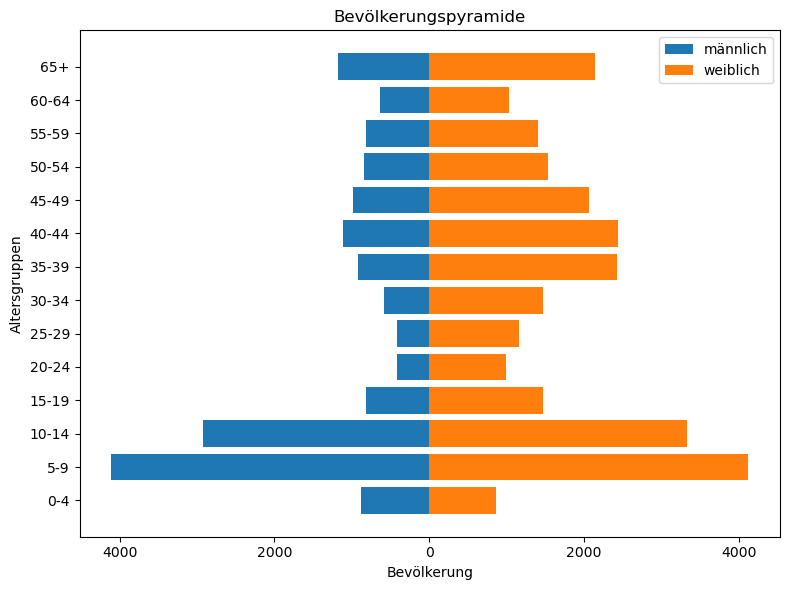

In [120]:

# Définition des classes d’âge (0–4, 5–9, ..., 60–64, 65+)
bins = list(range(0, 66, 5)) + [200]   # => [0,5,10,...,65,200]
labels = [f"{i}-{i+4}" for i in range(0, 65, 5)] + ["65+"]

# Créer les classes
LesAkt_df['Altersgruppe'] = pd.cut(
    LesAkt_df['Alter'],
    bins=bins,
    labels=labels,
    right=False
)

# Compter par sexe et tranche d’âge
age_pyramid = LesAkt_df.groupby(['Altersgruppe', 'Geschlecht']).size().unstack(fill_value=0)

# Création du graphique
fig, ax = plt.subplots(figsize=(8,6))

# Hommes à gauche (valeurs négatives)
ax.barh(age_pyramid.index.astype(str), -age_pyramid.get('M', 0), label='männlich')

# Femmes à droite (valeurs positives)
ax.barh(age_pyramid.index.astype(str),  age_pyramid.get('W', 0), label='weiblich')

# Titres et axes en allemand
ax.set_xlabel("Bevölkerung")
ax.set_ylabel("Altersgruppen")
ax.set_title("Bevölkerungspyramide")
ax.legend()

# ✅ Transformer les ticks de l’axe X en valeurs absolues
xticks = ax.get_xticks()
ax.set_xticklabels([abs(int(x)) for x in xticks])

plt.tight_layout()
plt.show()


/var/folders/_w/syp13sn960j6v43pwrmhdn2r0000gp/T/ipykernel_3036/2119671361.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_pyramid_global = LesAkt_df.groupby(['Altersgruppe', 'Geschlecht']).size().unstack(fill_value=0)
/var/folders/_w/syp13sn960j6v43pwrmhdn2r0000gp/T/ipykernel_3036/2119671361.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([abs(int(x)) for x in ax.get_xticks()])
/var/folders/_w/syp13sn960j6v43pwrmhdn2r0000gp/T/ipykernel_3036/2119671361.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([abs(int(x)) for x in ax2.get_xticks()])


Index(['Männlich', 'Weiblich'], dtype='object')


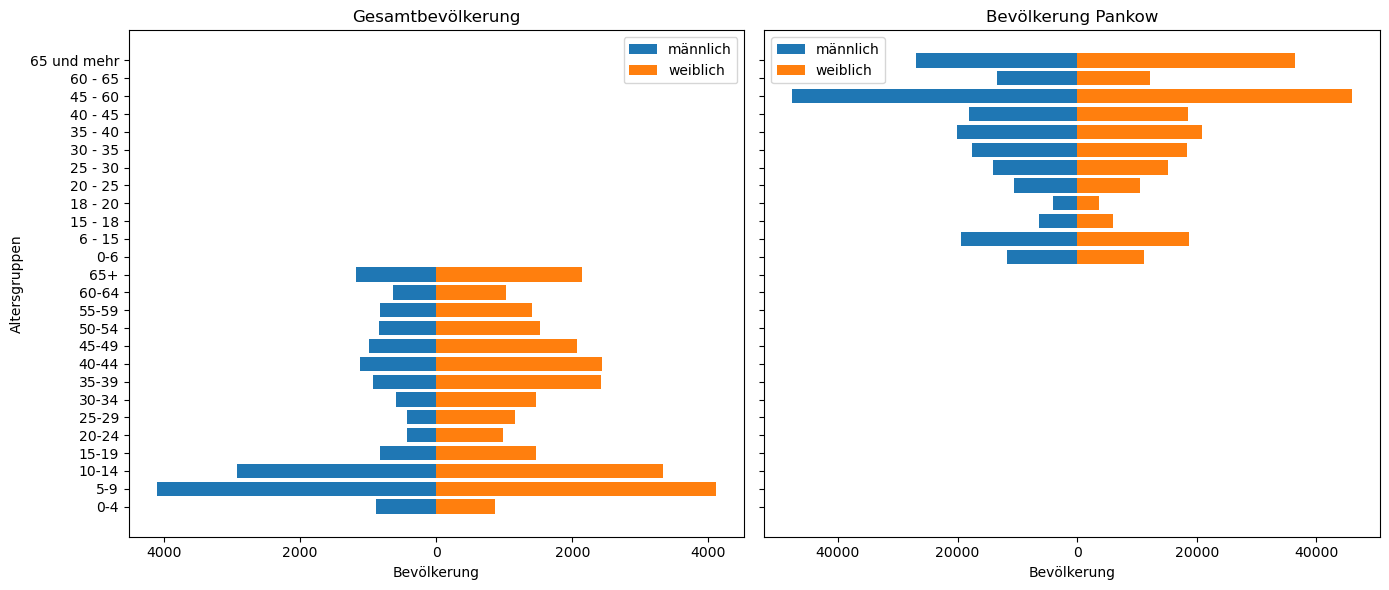

In [134]:

# ---------------------------
# 1️⃣ Pyramide globale
# ---------------------------
# Catégoriser les âges
bins = list(range(0, 66, 5)) + [200]
labels = [f"{i}-{i+4}" for i in range(0, 65, 5)] + ["65+"]

LesAkt_df['Altersgruppe'] = pd.cut(
    LesAkt_df['Alter'],
    bins=bins,
    labels=labels,
    right=False
)

age_pyramid_global = LesAkt_df.groupby(['Altersgruppe', 'Geschlecht']).size().unstack(fill_value=0)

# ---------------------------
# 2️⃣ Pyramide Pankow
# ---------------------------
# Transposer si nécessaire pour avoir
# Index = tranches d'âge, Colonnes = genres
Alter_Geschlecht_df = Alter_Geschlecht_df.T

# Vérifier les colonnes
print(Alter_Geschlecht_df.columns)  # doit être ['Männlich', 'Weiblich']

# ---------------------------
# 3️⃣ Création du subplot
# ---------------------------
fig, axes = plt.subplots(ncols=2, figsize=(14, 6), sharey=True)

# 🔹 Pyramide globale
ax = axes[0]
ax.barh(age_pyramid_global.index.astype(str), -age_pyramid_global.get('M', 0), label='männlich')
ax.barh(age_pyramid_global.index.astype(str),  age_pyramid_global.get('W', 0), label='weiblich')
ax.set_xlabel("Bevölkerung")
ax.set_ylabel("Altersgruppen")
ax.set_title("Gesamtbevölkerung")
ax.legend()

# Étiquettes X positives
ax.set_xticklabels([abs(int(x)) for x in ax.get_xticks()])

# 🔹 Pyramide Pankow
ax2 = axes[1]
ax2.barh(Alter_Geschlecht_df.index, -Alter_Geschlecht_df['Männlich'], label='männlich')
ax2.barh(Alter_Geschlecht_df.index,  Alter_Geschlecht_df['Weiblich'], label='weiblich')
ax2.set_xlabel("Bevölkerung")
ax2.set_title("Bevölkerung Pankow")
ax2.legend()
ax2.set_xticklabels([abs(int(x)) for x in ax2.get_xticks()])

plt.tight_layout()
plt.show()


/var/folders/_w/syp13sn960j6v43pwrmhdn2r0000gp/T/ipykernel_3036/4204293674.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_pyramid_global = LesAkt_df.groupby(['Altersgruppe', 'Geschlecht']).size().unstack(fill_value=0)
/var/folders/_w/syp13sn960j6v43pwrmhdn2r0000gp/T/ipykernel_3036/4204293674.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([abs(int(x)) for x in ax.get_xticks()])
/var/folders/_w/syp13sn960j6v43pwrmhdn2r0000gp/T/ipykernel_3036/4204293674.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([abs(int(x)) for x in ax2.get_xticks()])


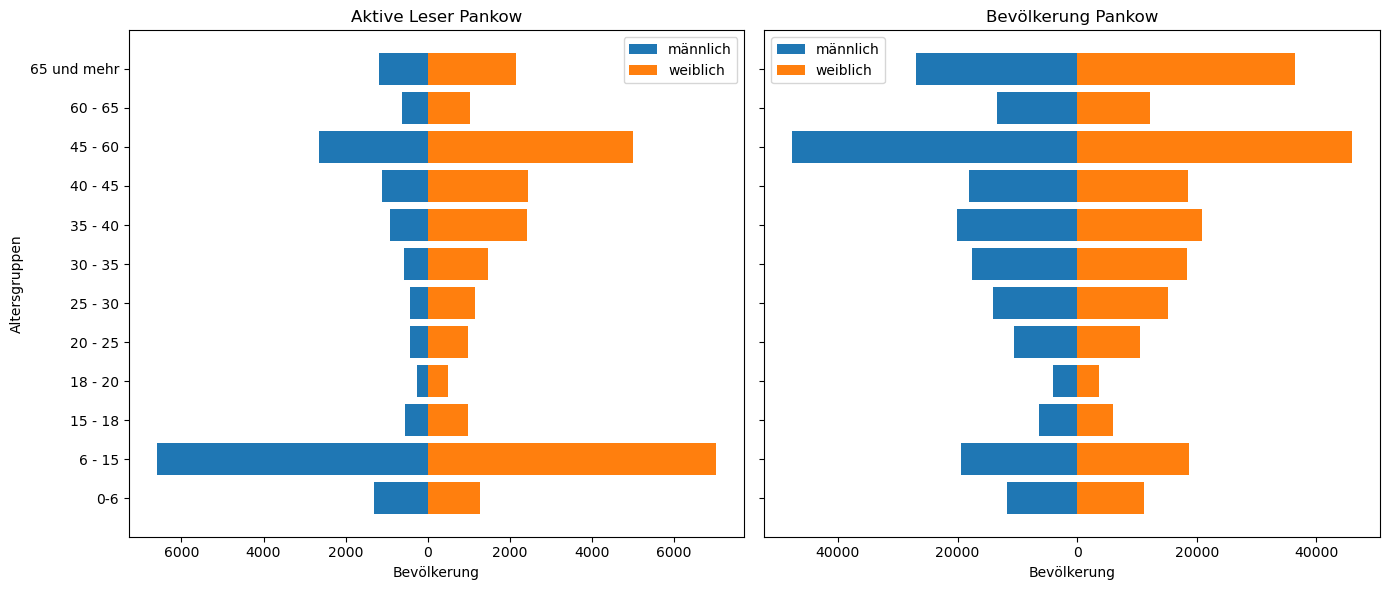

In [136]:

# Définir les tranches d'âge
age_labels = ['0-6', '6 - 15', '15 - 18', '18 - 20', '20 - 25', 
              '25 - 30', '30 - 35', '35 - 40', '40 - 45', '45 - 60', 
              '60 - 65', '65 und mehr']

# ---------------------------
# 1️⃣ Pyramide globale
# ---------------------------
# Catégoriser les âges avec les mêmes groupes que Pankow
LesAkt_df['Altersgruppe'] = pd.cut(
    LesAkt_df['Alter'],
    bins=[0,6,15,18,20,25,30,35,40,45,60,65,200],
    labels=age_labels,
    right=False
)

# Grouper et remplir les valeurs manquantes avec 0
age_pyramid_global = LesAkt_df.groupby(['Altersgruppe', 'Geschlecht']).size().unstack(fill_value=0)

# S'assurer que toutes les tranches sont présentes
age_pyramid_global = age_pyramid_global.reindex(age_labels, fill_value=0)

# ---------------------------
# 2️⃣ Pyramide Pankow
# ---------------------------
# Index = tranches d'âge, Colonnes = ['Männlich', 'Weiblich']
Alter_Geschlecht_df = Alter_Geschlecht_df.reindex(age_labels, fill_value=0)

# ---------------------------
# 3️⃣ Création du subplot
# ---------------------------
fig, axes = plt.subplots(ncols=2, figsize=(14, 6), sharey=True)

# 🔹 Pyramide globale
ax = axes[0]
ax.barh(age_pyramid_global.index, -age_pyramid_global.get('M',0), label='männlich')
ax.barh(age_pyramid_global.index,  age_pyramid_global.get('W',0), label='weiblich')
ax.set_xlabel("Bevölkerung")
ax.set_ylabel("Altersgruppen")
ax.set_title("Aktive Leser Pankow")
ax.legend()
ax.set_xticklabels([abs(int(x)) for x in ax.get_xticks()])

# 🔹 Pyramide Pankow
ax2 = axes[1]
ax2.barh(Alter_Geschlecht_df.index, -Alter_Geschlecht_df['Männlich'], label='männlich')
ax2.barh(Alter_Geschlecht_df.index,  Alter_Geschlecht_df['Weiblich'], label='weiblich')
ax2.set_xlabel("Bevölkerung")
ax2.set_title("Bevölkerung Pankow")
ax2.legend()
ax2.set_xticklabels([abs(int(x)) for x in ax2.get_xticks()])

plt.tight_layout()
plt.show()


# The end